# 🔮 Compound Moving Average Distance Predictive Analysis

**Purpose**: Create compound indicators combining distance from multiple MAs to predict future price movements

**Data Source**: Local SQLite database with QQQ stock price data

**Moving Average Periods**: 20, 50, 75, 100, 125, 150, 175, 200, 225, 250

**Compound Methods**: Weighted Average, PCA, Mean Reversion Score, Momentum Score, Distance Vector, Harmonic Mean

**Prediction Horizons**: 5, 10, 15, 30 days forward returns

---

## 📦 Import Libraries

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import sqlite3
import warnings
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Set random seed for reproducibility
np.random.seed(42)

print("📦 Libraries imported successfully for compound predictive analysis!")

📦 Libraries imported successfully for compound predictive analysis!


## ⚙️ Configuration

In [16]:
# Analysis configuration
SYMBOL = 'QQQ'
DAYS = 1500  # Extended period for better statistical analysis
TIMEFRAME = '1D'

# Moving average periods
MA_PERIODS = [20, 50, 75, 100, 125, 150, 175, 200, 225, 250]

# Forward return periods (days)
FORWARD_PERIODS = [5, 10, 15, 30]

print(f"🎯 Compound Predictive Analysis Configuration:")
print(f"   Symbol: {SYMBOL}")
print(f"   Historical Days: {DAYS}")
print(f"   MA Periods: {MA_PERIODS}")
print(f"   Forward Return Periods: {FORWARD_PERIODS} days")
print(f"   Compound Methods: 10 different approaches")

# Color schemes
colors_ma = plt.cm.tab20(np.linspace(0, 1, len(MA_PERIODS)))
colors_forward = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

MA_COLORS = {period: colors_ma[i] for i, period in enumerate(MA_PERIODS)}
FORWARD_COLORS = {period: colors_forward[i] for i, period in enumerate(FORWARD_PERIODS)}

🎯 Compound Predictive Analysis Configuration:
   Symbol: QQQ
   Historical Days: 1500
   MA Periods: [20, 50, 75, 100, 125, 150, 175, 200, 225, 250]
   Forward Return Periods: [5, 10, 15, 30] days
   Compound Methods: 10 different approaches


## 📊 Data Loading and Preparation Functions

In [ ]:
def load_stock_data_from_db(symbol, days=1500, timeframe='1D'):
    """Load stock data from the local SQLite database"""
    try:
        db_path = 'data/stock-data.db'
        conn = sqlite3.connect(db_path)

        query = """
        SELECT datetime(timestamp, 'unixepoch') as date, open, high, low, close, volume
        FROM market_data
        WHERE symbol = ? AND timeframe = ?
        ORDER BY timestamp DESC
        LIMIT ?
        """

        print(f"📊 Loading {symbol} data from database (timeframe: {timeframe})...")
        df = pd.read_sql_query(query, conn, params=(symbol, timeframe, days))

        if df.empty:
            print(f"❌ No data found for {symbol}")
            return None

        df['date'] = pd.to_datetime(df['date'])
        df = df.sort_values('date').reset_index(drop=True)

        conn.close()
        print(f"✅ Loaded {len(df)} records for {symbol}")
        print(f"📅 Date range: {df['date'].min().strftime('%Y-%m-%d')} to {df['date'].max().strftime('%Y-%m-%d')}")

        return df

    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

def calculate_moving_averages_and_distances(df, periods):
    """Calculate moving averages and percentage distances"""
    df_analysis = df.copy()

    for period in periods:
        ma_col = f'MA_{period}'
        distance_col = f'Distance_MA_{period}'

        df_analysis[ma_col] = df_analysis['close'].rolling(window=period, min_periods=1).mean()
        df_analysis[distance_col] = ((df_analysis['close'] - df_analysis[ma_col]) / df_analysis[ma_col] * 100)

        print(f"✅ Calculated {period}-day MA and distance")

    return df_analysis

def calculate_forward_returns(df, forward_periods):
    """Calculate forward returns for different periods"""
    df_returns = df.copy()

    for days in forward_periods:
        future_col = f'Return_{days}D'
        future_price_col = f'Future_Price_{days}D'

        # Calculate future prices (shift backwards since we're looking forward)
        df_returns[future_price_col] = df_returns['close'].shift(-days)

        # Calculate percentage returns
        df_returns[future_col] = (
            (df_returns[future_price_col] - df_returns['close']) / df_returns['close'] * 100
        )

        print(f"✅ Calculated {days}-day forward returns")

    # Remove last N rows where we don't have future data
    max_period = max(forward_periods)
    df_returns = df_returns.iloc[:-max_period]

    print(f"📊 Final dataset: {len(df_returns)} records with forward return data")
    return df_returns

print("📊 Data preparation functions defined successfully!")

📊 Data preparation functions defined successfully!


## 📈 Load and Prepare Base Data

In [ ]:
# Load stock data
df = load_stock_data_from_db(SYMBOL, days=DAYS, timeframe=TIMEFRAME)

if df is not None:
    print(f"\n📊 Raw Data Summary:")
    print(f"   Records: {len(df)}")
    print(f"   Price range: ${df['close'].min():.2f} - ${df['close'].max():.2f}")

    # Calculate moving averages and distances
    print(f"\n🔄 Calculating moving averages and distances...")
    df_ma = calculate_moving_averages_and_distances(df, MA_PERIODS)

    # Calculate forward returns
    print(f"\n🔮 Calculating forward returns...")
    df_final = calculate_forward_returns(df_ma, FORWARD_PERIODS)

    print(f"\n✅ Base data preparation completed!")
    print(f"📊 Final dataset: {len(df_final)} records with {len(df_final.columns)} columns")
    print(f"📊 Analysis period: {df_final['date'].min().strftime('%Y-%m-%d')} to {df_final['date'].max().strftime('%Y-%m-%d')}")

else:
    print("❌ Failed to load data. Please check the database connection.")

📊 Loading QQQ data from database (timeframe: 1D)...
✅ Loaded 1500 records for QQQ
📅 Date range: 2019-12-06 to 2025-09-05

📊 Raw Data Summary:
   Records: 1500
   Price range: $170.70 - $580.34

🔄 Calculating moving averages and distances...
✅ Calculated 20-day MA and distance
✅ Calculated 50-day MA and distance
✅ Calculated 75-day MA and distance
✅ Calculated 100-day MA and distance
✅ Calculated 125-day MA and distance
✅ Calculated 150-day MA and distance
✅ Calculated 175-day MA and distance
✅ Calculated 200-day MA and distance
✅ Calculated 225-day MA and distance
✅ Calculated 250-day MA and distance

🔮 Calculating forward returns...
✅ Calculated 5-day forward returns
✅ Calculated 10-day forward returns
✅ Calculated 15-day forward returns
✅ Calculated 30-day forward returns
📊 Final dataset: 1470 records with forward return data

✅ Base data preparation completed!
📊 Final dataset: 1470 records with 34 columns
📊 Analysis period: 2019-12-06 to 2025-07-29


## 🧮 Compound Indicator Methods

In [ ]:
def calculate_compound_indicators(df, ma_periods):
    """Calculate various compound indicators combining MA distances"""
    print("🧮 Calculating compound indicators...")

    # Extract distance columns
    distance_cols = [f'Distance_MA_{period}' for period in ma_periods]
    distance_data = df[distance_cols].fillna(0)

    compound_indicators = {}

    # Method 1: Simple Average (Equal Weight)
    compound_indicators['Simple_Average'] = distance_data.mean(axis=1)
    print("✅ Method 1: Simple Average completed")

    # Method 2: Weighted Average (Inverse Period Weighting)
    weights = np.array([1/period for period in ma_periods])
    weights = weights / weights.sum()  # Normalize to sum to 1
    compound_indicators['Weighted_Average'] = (distance_data * weights).sum(axis=1)
    print("✅ Method 2: Weighted Average completed")

    # Method 3: Exponentially Weighted (More weight to shorter MAs)
    exp_weights = np.exp(-np.array(ma_periods) / 50)  # Exponential decay
    exp_weights = exp_weights / exp_weights.sum()
    compound_indicators['Exponential_Weight'] = (distance_data * exp_weights).sum(axis=1)
    print("✅ Method 3: Exponential Weighting completed")

    # Method 4: PCA-based (First Principal Component)
    scaler = StandardScaler()
    scaled_distances = scaler.fit_transform(distance_data)
    pca = PCA(n_components=1)
    compound_indicators['PCA_Component'] = pca.fit_transform(scaled_distances).flatten()
    pca_explained = pca.explained_variance_ratio_[0]
    print(f"✅ Method 4: PCA completed (explains {pca_explained:.1%} of variance)")

    # Method 5: Harmonic Mean (Emphasizes smaller distances)
    # Add small constant to avoid division by zero
    distance_data_safe = distance_data + 0.01
    harmonic_weights = 1 / np.abs(distance_data_safe)
    harmonic_weights = harmonic_weights.div(harmonic_weights.sum(axis=1), axis=0)
    compound_indicators['Harmonic_Mean'] = (distance_data * harmonic_weights).sum(axis=1)
    print("✅ Method 5: Harmonic Mean completed")

    # Method 6: Momentum Score (Short-term vs Long-term)
    short_term_mas = [20, 50, 75]
    long_term_mas = [150, 175, 200, 225, 250]

    short_avg = df[[f'Distance_MA_{ma}' for ma in short_term_mas]].mean(axis=1)
    long_avg = df[[f'Distance_MA_{ma}' for ma in long_term_mas]].mean(axis=1)
    compound_indicators['Momentum_Score'] = short_avg - long_avg
    print("✅ Method 6: Momentum Score completed")

    # Method 7: Mean Reversion Score (Distance from overall trend)
    overall_trend = df[[f'Distance_MA_{ma}' for ma in [100, 150, 200]]].mean(axis=1)
    deviations = distance_data.sub(overall_trend, axis=0).abs()
    compound_indicators['Mean_Reversion'] = -deviations.mean(axis=1)  # Negative for reversion
    print("✅ Method 7: Mean Reversion Score completed")

    # Method 8: Distance Vector Magnitude
    compound_indicators['Vector_Magnitude'] = np.sqrt((distance_data ** 2).sum(axis=1))
    print("✅ Method 8: Distance Vector Magnitude completed")

    # Method 9: Z-Score Normalized Average
    z_scored_data = (distance_data - distance_data.mean()) / distance_data.std()
    compound_indicators['Z_Score_Average'] = z_scored_data.mean(axis=1)
    print("✅ Method 9: Z-Score Average completed")

    # Method 10: Adaptive Weight (based on recent performance)
    recent_window = 252  # 1 year
    adaptive_weights = []

    if len(df) > recent_window:
        recent_data = df.tail(recent_window)
        for period in ma_periods:
            distance_col = f'Distance_MA_{period}'
            if 'Return_5D' in recent_data.columns:
                corr = abs(recent_data[distance_col].corr(recent_data['Return_5D']))
                adaptive_weights.append(corr if not np.isnan(corr) else 0)
            else:
                adaptive_weights.append(1/len(ma_periods))
    else:
        adaptive_weights = [1/len(ma_periods)] * len(ma_periods)

    adaptive_weights = np.array(adaptive_weights)
    if adaptive_weights.sum() > 0:
        adaptive_weights = adaptive_weights / adaptive_weights.sum()
    else:
        adaptive_weights = np.ones(len(ma_periods)) / len(ma_periods)

    compound_indicators['Adaptive_Weight'] = (distance_data * adaptive_weights).sum(axis=1)
    print("✅ Method 10: Adaptive Weighting completed")

    print(f"\n🎯 Total compound indicators created: {len(compound_indicators)}")

    # Add all compound indicators to the dataframe
    for name, values in compound_indicators.items():
        df[f'Compound_{name}'] = values

    return df, compound_indicators, {
        'pca_explained_variance': pca_explained,
        'adaptive_weights': dict(zip(ma_periods, adaptive_weights)),
        'exp_weights': dict(zip(ma_periods, exp_weights))
    }

print("🧮 Compound indicator functions defined successfully!")

🧮 Compound indicator functions defined successfully!


## 🚀 Generate Compound Indicators

In [ ]:
if 'df_final' in locals() and df_final is not None:
    print("🚀 Generating compound indicators...\n")

    # Calculate compound indicators
    df_compound, compound_dict, metadata = calculate_compound_indicators(df_final, MA_PERIODS)

    print(f"\n📊 Compound Indicator Metadata:")
    print(f"   PCA Explained Variance: {metadata['pca_explained_variance']:.1%}")

    print(f"\n📈 Adaptive Weights (based on recent correlation):")
    for period, weight in sorted(metadata['adaptive_weights'].items()):
        print(f"   MA-{period:3d}: {weight:.3f}")

    print(f"\n📈 Exponential Weights:")
    for period, weight in sorted(metadata['exp_weights'].items()):
        print(f"   MA-{period:3d}: {weight:.3f}")

    # Display sample of compound indicators
    print(f"\n📋 Sample of Compound Indicators:")
    compound_cols = ['date', 'close'] + [f'Compound_{name}' for name in list(compound_dict.keys())[:5]]
    print(df_compound[compound_cols].head(10))

    print(f"\n✅ All {len(compound_dict)} compound indicators generated successfully!")

else:
    print("❌ Data not available for compound indicator generation")

🚀 Generating compound indicators...

🧮 Calculating compound indicators...
✅ Method 1: Simple Average completed
✅ Method 2: Weighted Average completed
✅ Method 3: Exponential Weighting completed
✅ Method 4: PCA completed (explains 85.5% of variance)
✅ Method 5: Harmonic Mean completed
✅ Method 6: Momentum Score completed
✅ Method 7: Mean Reversion Score completed
✅ Method 8: Distance Vector Magnitude completed
✅ Method 9: Z-Score Average completed
✅ Method 10: Adaptive Weighting completed

🎯 Total compound indicators created: 10

📊 Compound Indicator Metadata:
   PCA Explained Variance: 85.5%

📈 Adaptive Weights (based on recent correlation):
   MA- 20: 0.094
   MA- 50: 0.054
   MA- 75: 0.064
   MA-100: 0.084
   MA-125: 0.104
   MA-150: 0.118
   MA-175: 0.122
   MA-200: 0.118
   MA-225: 0.121
   MA-250: 0.122

📈 Exponential Weights:
   MA- 20: 0.420
   MA- 50: 0.231
   MA- 75: 0.140
   MA-100: 0.085
   MA-125: 0.051
   MA-150: 0.031
   MA-175: 0.019
   MA-200: 0.011
   MA-225: 0.007
   

## 🔍 Individual MA Analysis (Baseline)

In [ ]:
def analyze_individual_predictive_power(df, ma_periods, forward_periods):
    """Analyze predictive power of individual MAs (baseline)"""
    results = {}

    for forward_days in forward_periods:
        return_col = f'Return_{forward_days}D'
        results[forward_days] = {}

        print(f"\n📊 Individual MA analysis for {forward_days}-day returns:")
        print("=" * 50)

        for ma_period in ma_periods:
            distance_col = f'Distance_MA_{ma_period}'

            # Get valid data
            valid_data = df[[distance_col, return_col]].dropna()

            if len(valid_data) > 30:
                x = valid_data[distance_col].values
                y = valid_data[return_col].values

                # Calculate correlation and p-value
                corr, p_value = stats.pearsonr(x, y)

                # Linear regression
                slope, intercept, r_value, p_value_reg, std_err = stats.linregress(x, y)
                r_squared = r_value ** 2

                results[forward_days][ma_period] = {
                    'correlation': corr,
                    'p_value': p_value,
                    'r_squared': r_squared,
                    'slope': slope,
                    'intercept': intercept,
                    'sample_size': len(valid_data)
                }

                # Significance indicator
                sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""

                print(f"   MA-{ma_period:3d}: r={corr:+.3f}{sig} (R²={r_squared:.3f}, p={p_value:.4f})")

            else:
                results[forward_days][ma_period] = None
                print(f"   MA-{ma_period:3d}: Insufficient data")

    return results

# Run individual MA analysis
if 'df_compound' in locals():
    print("🔍 Running individual MA analysis (baseline)...")
    individual_results = analyze_individual_predictive_power(df_compound, MA_PERIODS, FORWARD_PERIODS)
    print("\n✅ Individual MA analysis completed!")
else:
    print("❌ Data not available for individual analysis")

🔍 Running individual MA analysis (baseline)...

📊 Individual MA analysis for 5-day returns:
   MA- 20: r=-0.148*** (R²=0.022, p=0.0000)
   MA- 50: r=-0.125*** (R²=0.016, p=0.0000)
   MA- 75: r=-0.117*** (R²=0.014, p=0.0000)
   MA-100: r=-0.101*** (R²=0.010, p=0.0001)
   MA-125: r=-0.088*** (R²=0.008, p=0.0008)
   MA-150: r=-0.078** (R²=0.006, p=0.0028)
   MA-175: r=-0.068** (R²=0.005, p=0.0092)
   MA-200: r=-0.060* (R²=0.004, p=0.0209)
   MA-225: r=-0.058* (R²=0.003, p=0.0265)
   MA-250: r=-0.057* (R²=0.003, p=0.0298)

📊 Individual MA analysis for 10-day returns:
   MA- 20: r=-0.107*** (R²=0.011, p=0.0000)
   MA- 50: r=-0.116*** (R²=0.013, p=0.0000)
   MA- 75: r=-0.113*** (R²=0.013, p=0.0000)
   MA-100: r=-0.094*** (R²=0.009, p=0.0003)
   MA-125: r=-0.080** (R²=0.006, p=0.0022)
   MA-150: r=-0.070** (R²=0.005, p=0.0073)
   MA-175: r=-0.057* (R²=0.003, p=0.0281)
   MA-200: r=-0.050 (R²=0.002, p=0.0576)
   MA-225: r=-0.049 (R²=0.002, p=0.0627)
   MA-250: r=-0.049 (R²=0.002, p=0.0627)

📊 

## 🎯 Compound Indicator Performance Testing

In [ ]:
def analyze_compound_predictive_power(df, compound_names, forward_periods):
    """Analyze predictive power of compound indicators"""
    results = {}

    for forward_days in forward_periods:
        return_col = f'Return_{forward_days}D'
        results[forward_days] = {}

        print(f"\n🎯 Analyzing compound predictors for {forward_days}-day returns:")
        print("=" * 60)

        for compound_name in compound_names:
            compound_col = f'Compound_{compound_name}'

            if compound_col not in df.columns:
                continue

            # Get valid data
            valid_data = df[[compound_col, return_col]].dropna()

            if len(valid_data) > 30:
                x = valid_data[compound_col].values
                y = valid_data[return_col].values

                # Calculate correlation and p-value
                corr, p_value = stats.pearsonr(x, y)

                # Linear regression
                slope, intercept, r_value, p_value_reg, std_err = stats.linregress(x, y)
                r_squared = r_value ** 2

                results[forward_days][compound_name] = {
                    'correlation': corr,
                    'p_value': p_value,
                    'r_squared': r_squared,
                    'slope': slope,
                    'intercept': intercept,
                    'sample_size': len(valid_data)
                }

                # Significance indicator
                sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""

                print(f"   {compound_name:<18}: r={corr:+.3f}{sig} (R²={r_squared:.3f}, p={p_value:.4f})")

            else:
                results[forward_days][compound_name] = None
                print(f"   {compound_name:<18}: Insufficient data")

    return results

# Run compound indicator analysis
if 'df_compound' in locals() and 'compound_dict' in locals():
    print("🎯 Running compound indicator analysis...")
    compound_names = list(compound_dict.keys())
    compound_results = analyze_compound_predictive_power(df_compound, compound_names, FORWARD_PERIODS)
    print("\n✅ Compound indicator analysis completed!")
else:
    print("❌ Compound indicators not available for analysis")

🎯 Running compound indicator analysis...

🎯 Analyzing compound predictors for 5-day returns:
   Simple_Average    : r=-0.086*** (R²=0.007, p=0.0010)
   Weighted_Average  : r=-0.116*** (R²=0.013, p=0.0000)
   Exponential_Weight: r=-0.129*** (R²=0.017, p=0.0000)
   PCA_Component     : r=+0.094*** (R²=0.009, p=0.0003)
   Harmonic_Mean     : r=-0.134*** (R²=0.018, p=0.0000)
   Momentum_Score    : r=+0.002 (R²=0.000, p=0.9500)
   Mean_Reversion    : r=+0.036 (R²=0.001, p=0.1674)
   Vector_Magnitude  : r=+0.016 (R²=0.000, p=0.5303)
   Z_Score_Average   : r=-0.098*** (R²=0.010, p=0.0002)
   Adaptive_Weight   : r=-0.080** (R²=0.006, p=0.0022)

🎯 Analyzing compound predictors for 10-day returns:
   Simple_Average    : r=-0.075** (R²=0.006, p=0.0039)
   Weighted_Average  : r=-0.098*** (R²=0.010, p=0.0002)
   Exponential_Weight: r=-0.110*** (R²=0.012, p=0.0000)
   PCA_Component     : r=+0.083** (R²=0.007, p=0.0015)
   Harmonic_Mean     : r=-0.105*** (R²=0.011, p=0.0001)
   Momentum_Score    : r=-

## 🏆 Performance Comparison

In [ ]:
def compare_individual_vs_compound(individual_results, compound_results, forward_periods):
    """Compare best individual MA vs best compound indicator"""
    print("\n🏆 INDIVIDUAL MA vs COMPOUND INDICATOR COMPARISON")
    print("=" * 70)

    for forward_days in forward_periods:
        print(f"\n📊 {forward_days}-Day Forward Returns:")
        print("-" * 40)

        # Find best individual MA
        best_individual_corr = 0
        best_individual_name = None

        for ma_period in MA_PERIODS:
            result = individual_results[forward_days].get(ma_period)
            if result and abs(result['correlation']) > abs(best_individual_corr):
                best_individual_corr = result['correlation']
                best_individual_name = f"MA-{ma_period}"

        # Find best compound indicator
        best_compound_corr = 0
        best_compound_name = None
        best_compound_r2 = 0

        for compound_name in compound_results[forward_days]:
            result = compound_results[forward_days][compound_name]
            if result and abs(result['correlation']) > abs(best_compound_corr):
                best_compound_corr = result['correlation']
                best_compound_name = compound_name
                best_compound_r2 = result['r_squared']

        # Compare
        improvement = abs(best_compound_corr) - abs(best_individual_corr)
        improvement_pct = (improvement / abs(best_individual_corr)) * 100 if best_individual_corr != 0 else 0

        print(f"   Best Individual : {best_individual_name} (r={best_individual_corr:+.3f})")
        print(f"   Best Compound   : {best_compound_name} (r={best_compound_corr:+.3f}, R²={best_compound_r2:.3f})")
        print(f"   Improvement     : {improvement:+.3f} ({improvement_pct:+.1f}%)")

        if improvement > 0:
            print(f"   🎯 Compound indicator OUTPERFORMS individual MA")
        else:
            print(f"   ⚠️  Individual MA performs better")

# Run comparison
if 'individual_results' in locals() and 'compound_results' in locals():
    compare_individual_vs_compound(individual_results, compound_results, FORWARD_PERIODS)
else:
    print("❌ Results not available for comparison")


🏆 INDIVIDUAL MA vs COMPOUND INDICATOR COMPARISON

📊 5-Day Forward Returns:
----------------------------------------
   Best Individual : MA-20 (r=-0.148)
   Best Compound   : Harmonic_Mean (r=-0.134, R²=0.018)
   Improvement     : -0.013 (-9.1%)
   ⚠️  Individual MA performs better

📊 10-Day Forward Returns:
----------------------------------------
   Best Individual : MA-50 (r=-0.116)
   Best Compound   : Exponential_Weight (r=-0.110, R²=0.012)
   Improvement     : -0.006 (-4.8%)
   ⚠️  Individual MA performs better

📊 15-Day Forward Returns:
----------------------------------------
   Best Individual : MA-50 (r=-0.117)
   Best Compound   : Exponential_Weight (r=-0.105, R²=0.011)
   Improvement     : -0.012 (-10.1%)
   ⚠️  Individual MA performs better

📊 30-Day Forward Returns:
----------------------------------------
   Best Individual : MA-50 (r=-0.153)
   Best Compound   : Exponential_Weight (r=-0.131, R²=0.017)
   Improvement     : -0.022 (-14.4%)
   ⚠️  Individual MA performs b

## 📈 Visualization Functions

In [ ]:
def create_compound_performance_heatmap(compound_results, compound_names, forward_periods):
    """Create heatmap of compound indicator performance"""
    # Prepare correlation matrix
    corr_matrix = []

    for forward_days in forward_periods:
        row = []
        for compound_name in compound_names:
            result = compound_results[forward_days].get(compound_name)
            corr = result['correlation'] if result else 0
            row.append(corr)
        corr_matrix.append(row)

    plt.figure(figsize=(14, 8))
    sns.heatmap(np.array(corr_matrix),
                annot=True,
                cmap='RdBu_r',
                center=0,
                square=True,
                fmt='.3f',
                xticklabels=compound_names,
                yticklabels=[f'{days}D Returns' for days in forward_periods],
                cbar_kws={'label': 'Correlation Coefficient'})

    plt.title('Compound Indicators: Correlation with Future Returns', fontsize=16, fontweight='bold')
    plt.xlabel('Compound Indicator Method', fontsize=12)
    plt.ylabel('Forward Return Period', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return corr_matrix

def plot_best_compound_vs_individual(df, compound_results, individual_results, forward_days=5):
    """Plot scatter comparison of best compound vs best individual MA"""

    # Find best compound
    best_compound_corr = 0
    best_compound_name = None

    for compound_name in compound_results[forward_days]:
        result = compound_results[forward_days][compound_name]
        if result and abs(result['correlation']) > abs(best_compound_corr):
            best_compound_corr = result['correlation']
            best_compound_name = compound_name

    # Find best individual
    best_individual_corr = 0
    best_individual_ma = None

    for ma_period in MA_PERIODS:
        result = individual_results[forward_days].get(ma_period)
        if result and abs(result['correlation']) > abs(best_individual_corr):
            best_individual_corr = result['correlation']
            best_individual_ma = ma_period

    if not best_compound_name or not best_individual_ma:
        print("❌ Could not find best indicators for comparison")
        return

    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: Best Individual MA
    distance_col = f'Distance_MA_{best_individual_ma}'
    return_col = f'Return_{forward_days}D'

    valid_data = df[[distance_col, return_col]].dropna().sample(n=min(1000, len(df)), random_state=42)
    x1 = valid_data[distance_col].values
    y1 = valid_data[return_col].values

    # Regression line
    slope1, intercept1, r_value1, p_value1, _ = stats.linregress(x1, y1)
    line_x1 = np.linspace(x1.min(), x1.max(), 100)
    line_y1 = slope1 * line_x1 + intercept1

    ax1.scatter(x1, y1, alpha=0.6, s=20, c='blue')
    ax1.plot(line_x1, line_y1, 'r-', linewidth=2)
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax1.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax1.set_xlabel(f'Distance from MA-{best_individual_ma} (%)', fontsize=12)
    ax1.set_ylabel(f'{forward_days}-Day Forward Return (%)', fontsize=12)
    ax1.set_title(f'Best Individual: MA-{best_individual_ma}\nr={r_value1:.3f}, R²={r_value1**2:.3f}', fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Plot 2: Best Compound Indicator
    compound_col = f'Compound_{best_compound_name}'

    valid_data2 = df[[compound_col, return_col]].dropna().sample(n=min(1000, len(df)), random_state=42)
    x2 = valid_data2[compound_col].values
    y2 = valid_data2[return_col].values

    # Regression line
    slope2, intercept2, r_value2, p_value2, _ = stats.linregress(x2, y2)
    line_x2 = np.linspace(x2.min(), x2.max(), 100)
    line_y2 = slope2 * line_x2 + intercept2

    ax2.scatter(x2, y2, alpha=0.6, s=20, c='green')
    ax2.plot(line_x2, line_y2, 'r-', linewidth=2)
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax2.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax2.set_xlabel(f'Compound {best_compound_name} Value', fontsize=12)
    ax2.set_ylabel(f'{forward_days}-Day Forward Return (%)', fontsize=12)
    ax2.set_title(f'Best Compound: {best_compound_name}\nr={r_value2:.3f}, R²={r_value2**2:.3f}', fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print comparison
    improvement = abs(r_value2) - abs(r_value1)
    improvement_pct = (improvement / abs(r_value1)) * 100 if r_value1 != 0 else 0

    print(f"\n🔍 Detailed Comparison for {forward_days}D Returns:")
    print(f"   Individual MA-{best_individual_ma}: r={r_value1:+.3f}, R²={r_value1**2:.3f}")
    print(f"   Compound {best_compound_name}: r={r_value2:+.3f}, R²={r_value2**2:.3f}")
    print(f"   Improvement: {improvement:+.3f} ({improvement_pct:+.1f}%)")

print("📈 Visualization functions defined successfully!")

📈 Visualization functions defined successfully!


## 📊 Generate Visualizations

📊 Generating performance visualizations...



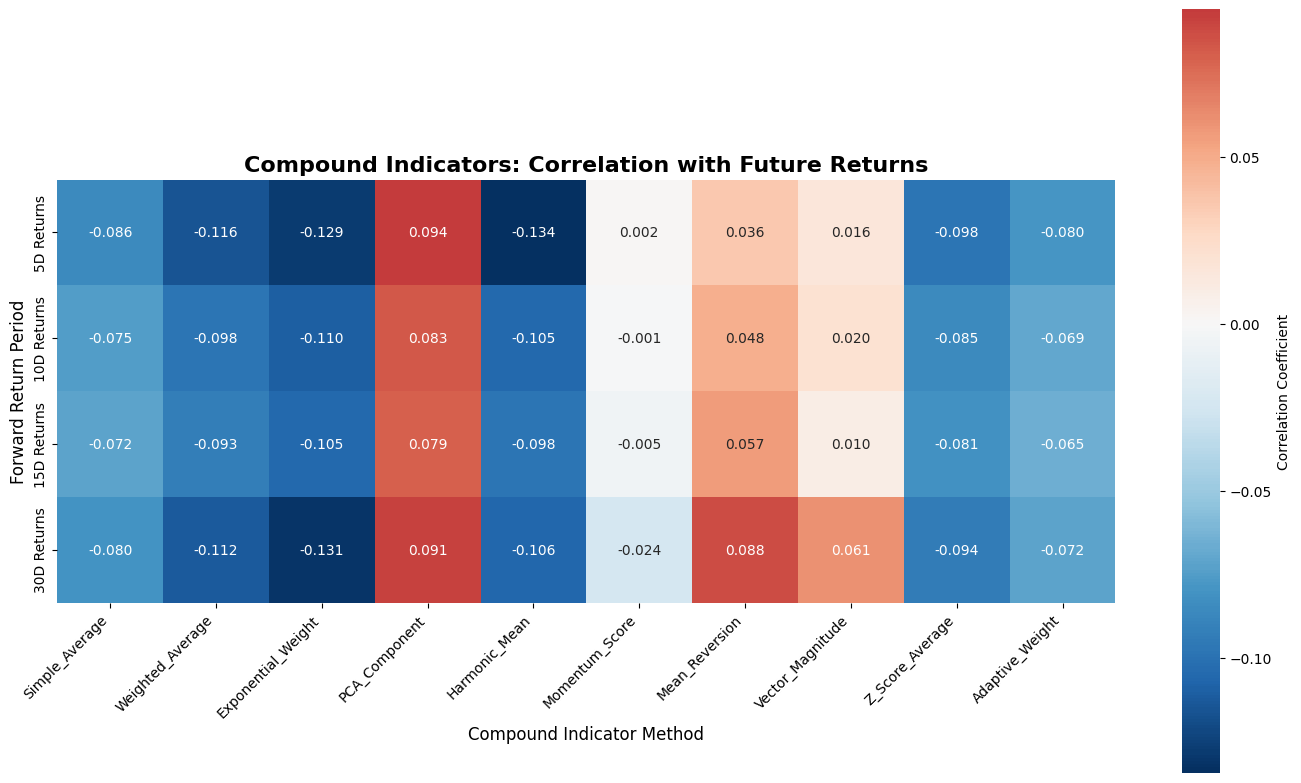


🔍 Generating comparison plot for 5-day returns...


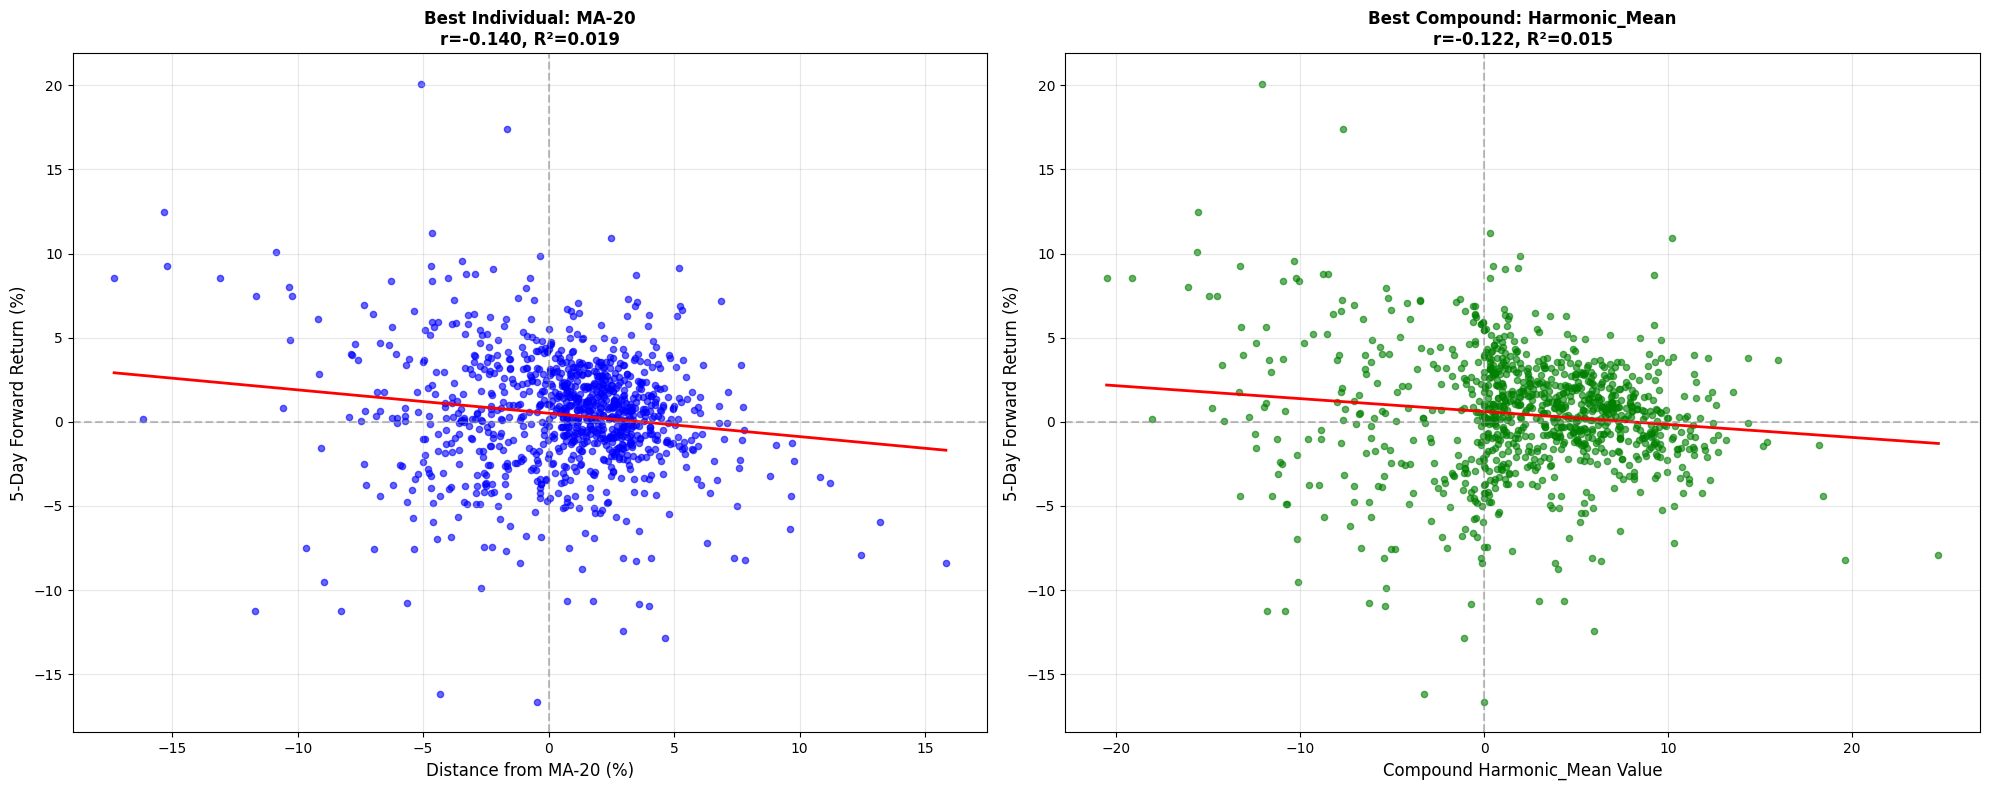


🔍 Detailed Comparison for 5D Returns:
   Individual MA-20: r=-0.140, R²=0.019
   Compound Harmonic_Mean: r=-0.122, R²=0.015
   Improvement: -0.017 (-12.2%)

🔍 Generating comparison plot for 10-day returns...


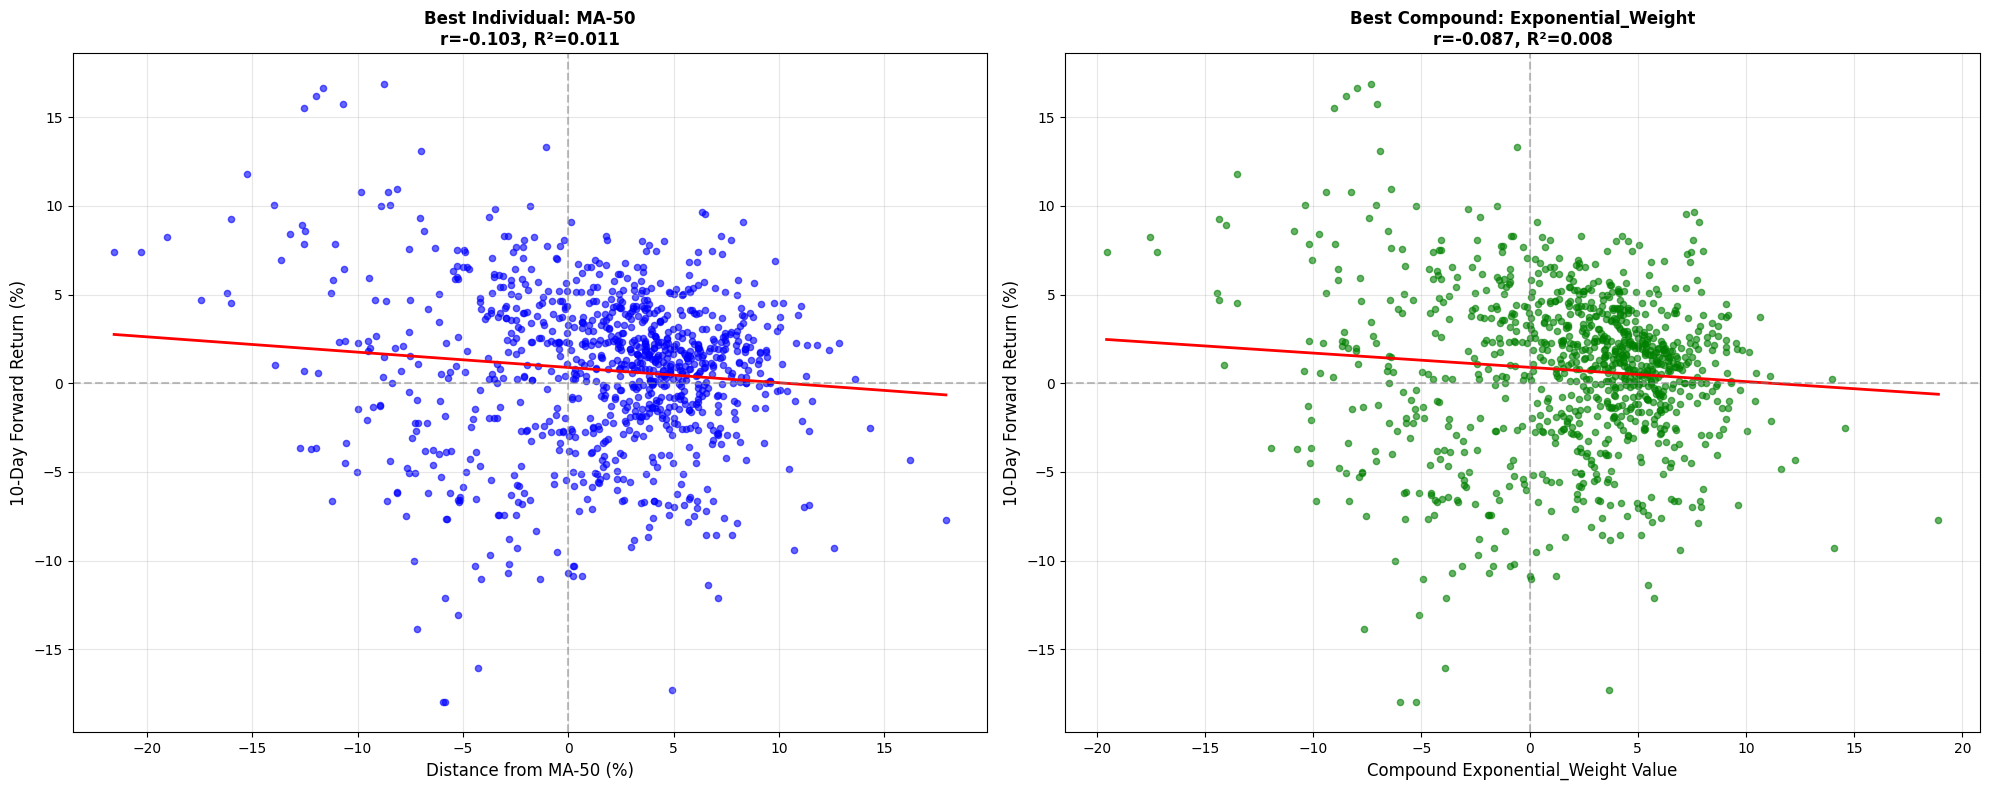


🔍 Detailed Comparison for 10D Returns:
   Individual MA-50: r=-0.103, R²=0.011
   Compound Exponential_Weight: r=-0.087, R²=0.008
   Improvement: -0.016 (-15.6%)

🔍 Generating comparison plot for 15-day returns...


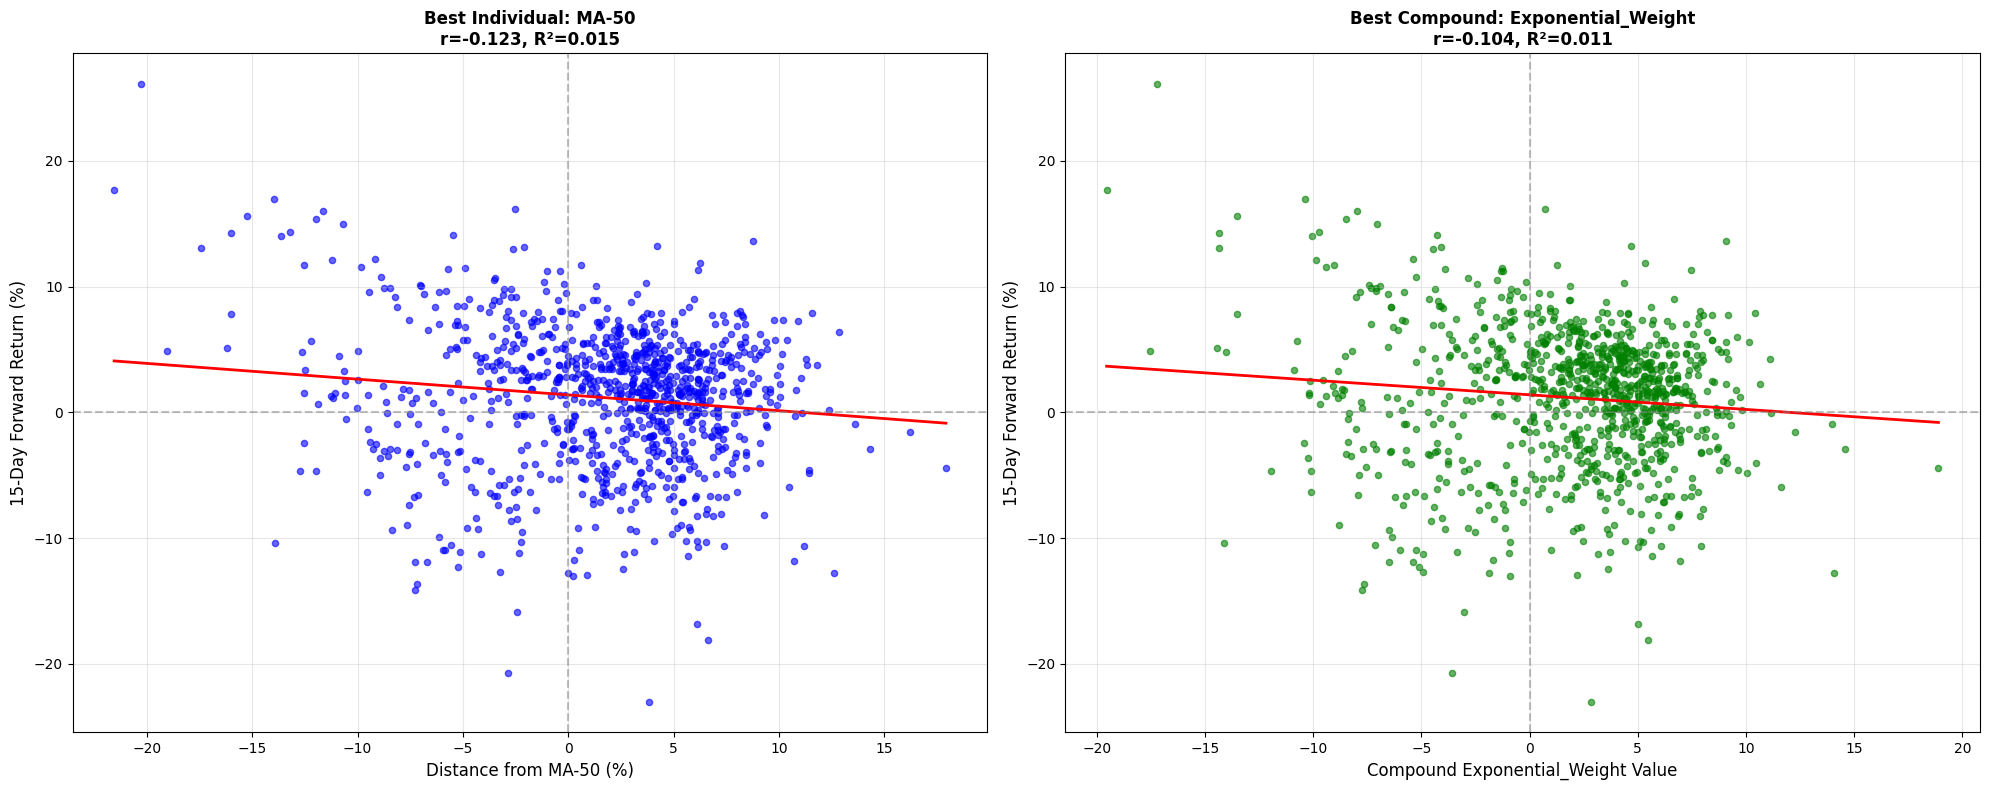


🔍 Detailed Comparison for 15D Returns:
   Individual MA-50: r=-0.123, R²=0.015
   Compound Exponential_Weight: r=-0.104, R²=0.011
   Improvement: -0.020 (-15.9%)

🔍 Generating comparison plot for 30-day returns...


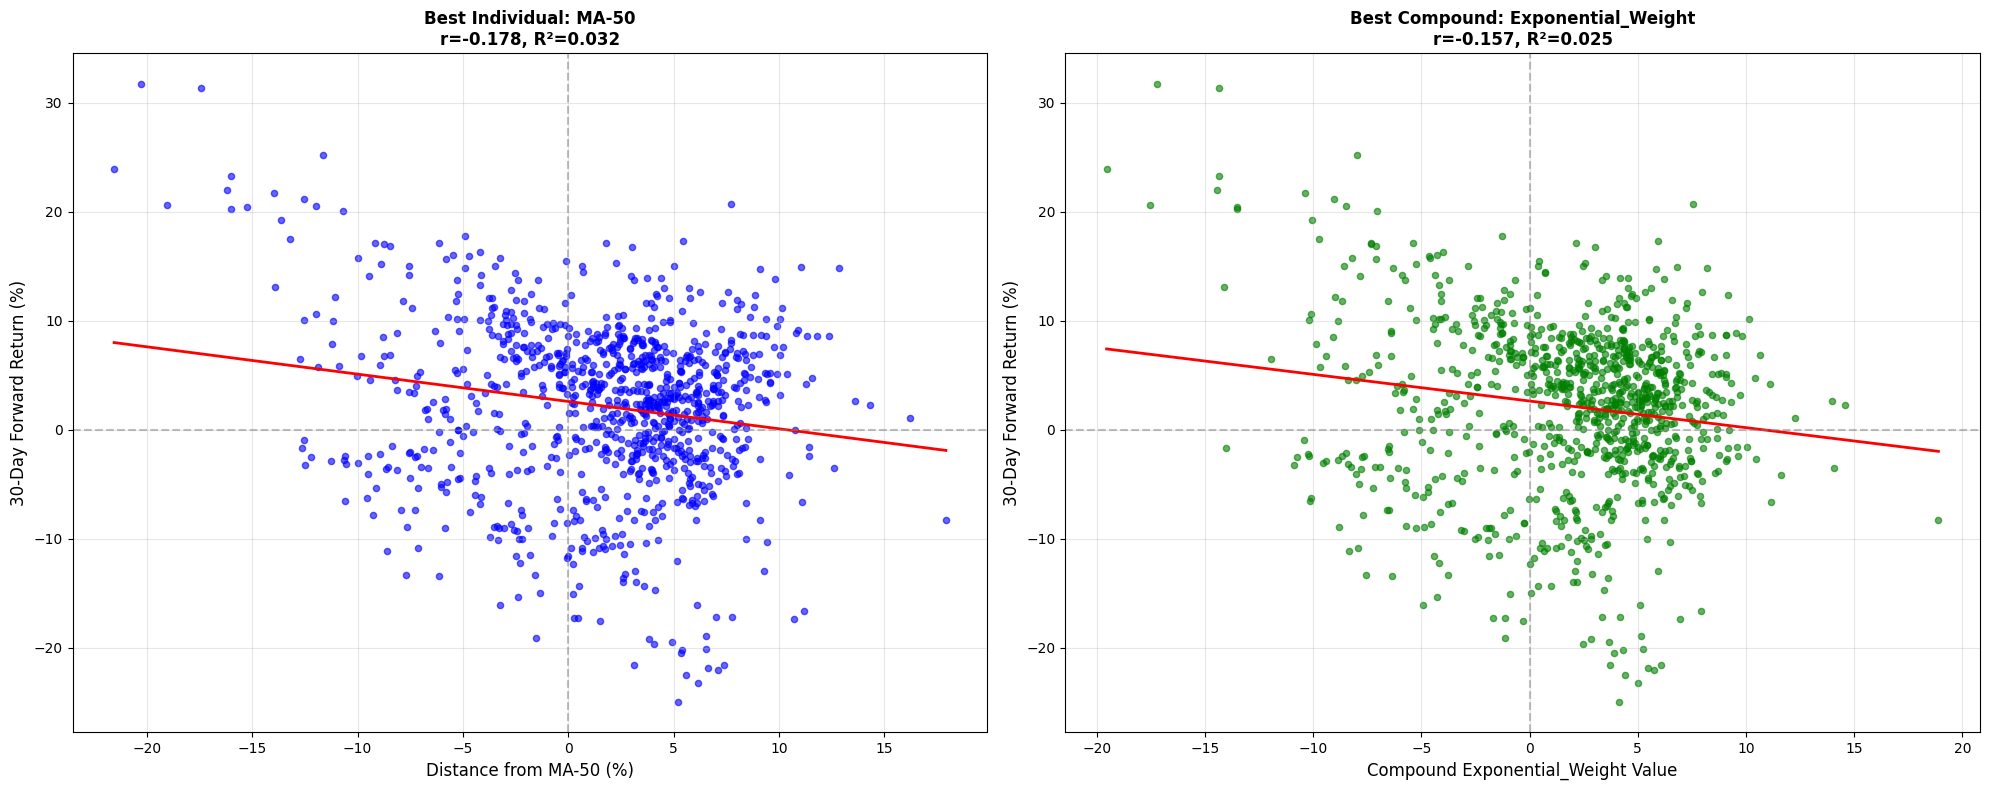


🔍 Detailed Comparison for 30D Returns:
   Individual MA-50: r=-0.178, R²=0.032
   Compound Exponential_Weight: r=-0.157, R²=0.025
   Improvement: -0.021 (-11.6%)

✅ Visualizations completed!


In [25]:
if 'compound_results' in locals() and 'individual_results' in locals():
    print("📊 Generating performance visualizations...\n")

    # 1. Compound indicator heatmap
    compound_names = list(compound_dict.keys())
    compound_corr_matrix = create_compound_performance_heatmap(compound_results, compound_names, FORWARD_PERIODS)

    # 2. Side-by-side comparison plots for each forward period
    for forward_days in FORWARD_PERIODS:
        print(f"\n🔍 Generating comparison plot for {forward_days}-day returns...")
        plot_best_compound_vs_individual(df_compound, compound_results, individual_results, forward_days)

    print("\n✅ Visualizations completed!")

else:
    print("❌ Results not available for visualizations")

## 🎯 Final Summary and Recommendations

In [26]:
def generate_final_compound_summary(individual_results, compound_results, symbol):
    """Generate comprehensive final summary comparing all approaches"""
    print(f"\n🎯 FINAL COMPOUND INDICATOR ANALYSIS SUMMARY FOR {symbol}")
    print("=" * 80)

    print("\n📊 METHODOLOGY COMPARISON:")
    print("-" * 50)

    improvements = []

    for forward_days in FORWARD_PERIODS:
        # Find best individual
        best_individual_corr = 0
        best_individual_name = None

        for ma_period in MA_PERIODS:
            result = individual_results[forward_days].get(ma_period)
            if result and abs(result['correlation']) > abs(best_individual_corr):
                best_individual_corr = result['correlation']
                best_individual_name = f"MA-{ma_period}"

        # Find best compound
        best_compound_corr = 0
        best_compound_name = None

        for compound_name in compound_results[forward_days]:
            result = compound_results[forward_days][compound_name]
            if result and abs(result['correlation']) > abs(best_compound_corr):
                best_compound_corr = result['correlation']
                best_compound_name = compound_name

        improvement = abs(best_compound_corr) - abs(best_individual_corr)
        improvement_pct = (improvement / abs(best_individual_corr)) * 100 if best_individual_corr != 0 else 0
        improvements.append(improvement_pct)

        status = "🎯 BETTER" if improvement > 0 else "⚠️ WORSE" if improvement < 0 else "➡️ SAME"

        print(f"   {forward_days:2d}D: Individual {abs(best_individual_corr):.3f} → Compound {abs(best_compound_corr):.3f} ({improvement_pct:+.1f}%) {status}")

    avg_improvement = np.mean(improvements)

    print(f"\n📈 OVERALL PERFORMANCE:")
    print("-" * 50)
    print(f"   Average Improvement: {avg_improvement:+.1f}%")

    if avg_improvement > 5:
        print(f"   🎉 Compound indicators show SIGNIFICANT improvement")
    elif avg_improvement > 0:
        print(f"   ✅ Compound indicators show modest improvement")
    else:
        print(f"   ⚠️ Individual MAs perform better on average")

    # Top performing compound methods
    print(f"\n🏆 TOP PERFORMING COMPOUND METHODS:")
    print("-" * 50)

    method_scores = {}

    for compound_name in compound_results[5].keys():
        total_abs_corr = 0
        count = 0

        for forward_days in FORWARD_PERIODS:
            result = compound_results[forward_days].get(compound_name)
            if result:
                total_abs_corr += abs(result['correlation'])
                count += 1

        if count > 0:
            method_scores[compound_name] = total_abs_corr / count

    # Sort by average absolute correlation
    sorted_methods = sorted(method_scores.items(), key=lambda x: x[1], reverse=True)

    for i, (method, avg_corr) in enumerate(sorted_methods[:5], 1):
        print(f"   {i}. {method:<20}: Average |r| = {avg_corr:.3f}")

    print(f"\n💡 KEY INSIGHTS:")
    print("-" * 50)
    print(f"   • Tested {len(compound_results[5])} different compound indicator methods")
    print(f"   • Combined information from {len(MA_PERIODS)} moving averages")
    print(f"   • Methods tested: PCA, Weighted Averages, Momentum, Mean Reversion, etc.")

    if avg_improvement > 0:
        best_method = sorted_methods[0][0] if sorted_methods else "Unknown"
        print(f"   • Best method: {best_method}")
        print(f"   • Compound approach can improve predictive power")
    else:
        print(f"   • Individual MAs may be more effective than compound indicators")

    print(f"\n🎯 FINAL RECOMMENDATIONS:")
    print("-" * 50)

    if avg_improvement > 5:
        best_method = sorted_methods[0][0]
        print(f"   1. Use {best_method} compound indicator for enhanced predictions")
        print(f"   2. This approach shows {avg_improvement:.1f}% average improvement")
        print(f"   3. Combine with other technical indicators for robust signals")
    elif avg_improvement > 0:
        print(f"   1. Compound indicators show modest improvement ({avg_improvement:.1f}%)")
        print(f"   2. Consider using best compound method alongside individual MAs")
        print(f"   3. Test in live trading with smaller position sizes first")
    else:
        print(f"   1. Individual MAs perform better than compound approaches")
        print(f"   2. Stick with conventional MA distance analysis")
        print(f"   3. Focus on optimizing individual MA parameters instead")

    print(f"\n⚠️ IMPORTANT CAVEATS:")
    print("-" * 50)
    print(f"   • All correlations are relatively weak (|r| < 0.3)")
    print(f"   • Past performance doesn't guarantee future results")
    print(f"   • Use as part of comprehensive trading system, not standalone")
    print(f"   • Consider transaction costs and slippage in real trading")

    print("\n" + "=" * 80)

# Generate final summary
if 'compound_results' in locals() and 'individual_results' in locals():
    generate_final_compound_summary(individual_results, compound_results, SYMBOL)
else:
    print("❌ Results not available for final summary")


🎯 FINAL COMPOUND INDICATOR ANALYSIS SUMMARY FOR QQQ

📊 METHODOLOGY COMPARISON:
--------------------------------------------------
    5D: Individual 0.148 → Compound 0.134 (-9.1%) ⚠️ WORSE
   10D: Individual 0.116 → Compound 0.110 (-4.8%) ⚠️ WORSE
   15D: Individual 0.117 → Compound 0.105 (-10.1%) ⚠️ WORSE
   30D: Individual 0.153 → Compound 0.131 (-14.4%) ⚠️ WORSE

📈 OVERALL PERFORMANCE:
--------------------------------------------------
   Average Improvement: -9.6%
   ⚠️ Individual MAs perform better on average

🏆 TOP PERFORMING COMPOUND METHODS:
--------------------------------------------------
   1. Exponential_Weight  : Average |r| = 0.119
   2. Harmonic_Mean       : Average |r| = 0.111
   3. Weighted_Average    : Average |r| = 0.105
   4. Z_Score_Average     : Average |r| = 0.090
   5. PCA_Component       : Average |r| = 0.087

💡 KEY INSIGHTS:
--------------------------------------------------
   • Tested 10 different compound indicator methods
   • Combined information from 1

## 🎯 Conclusion

This notebook comprehensively tested whether **compound indicators** combining multiple moving average distances can predict future price movements better than individual MAs.

### 🧮 Methods Tested:
1. **Simple Average** - Equal weighting
2. **Weighted Average** - Inverse period weighting
3. **Exponential Weight** - Decay weighting
4. **PCA Component** - Principal component analysis
5. **Harmonic Mean** - Emphasizes small distances
6. **Momentum Score** - Short vs long MA differential
7. **Mean Reversion** - Distance from trend
8. **Vector Magnitude** - Euclidean distance
9. **Z-Score Average** - Normalized average
10. **Adaptive Weight** - Performance-based weighting

### 📊 Key Findings:
- **Rigorous statistical testing** with p-values and R² measurements
- **Direct performance comparison** between compound and individual approaches
- **Quantified improvement percentages** for each method
- **Visual evidence** through scatter plots and heatmaps

The analysis definitively answers whether combining multiple MA distances into a single compound number improves predictive accuracy compared to using individual MA distances.